# Nearest Neighbors

* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

## Import libraries

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix      # sparse matrices
import numpy as np

In [5]:
## Load Wikipedia dataset
import pandas as pd
wiki = pd.read_csv('people_wiki.csv')

In [9]:
wiki.head(2)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...


In [10]:
wiki.shape

(59071, 3)

In [8]:
wiki['text'] = wiki['text'].apply(lambda review: review.lower())

In [11]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [12]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [14]:
word_count.shape

(59071, 547979)

## Find nearest neighbors using word count vectors

In [15]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [16]:
print(wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [18]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

In [212]:
list(distances[0:10])

[array([  0.        ,  33.07567082,  34.39476704,  36.15245497,
         36.16628264,  36.33180425,  36.40054945,  36.49657518,
         36.63331817,  36.95943723])]

In [29]:
wiki.iloc[indices[0]]

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...
35357,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...
14754,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...
13229,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...
31423,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...
22745,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...
36364,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...
9210,<http://dbpedia.org/resource/Andy_Anstett>,Andy Anstett,andrue john andy anstett born june 25 1946 is ...


All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

In [34]:
import json
with open('people_wiki_map_index_to_word.json', 'r') as f: 
    map_index_to_word = json.load(f)
# important_words = [str(s) for s in important_words]

In [36]:
len(map_index_to_word)

547979

In [43]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [178]:
import operator
from operator import itemgetter, attrgetter
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    #print(row.dtypes)
    #print(row['word_count'])
    #word_count_table = row[['word_count']].stack()
    row = row['word_count'].values[0]
    #word_count_table = row['word_count'].to_dict()
    #dc_sort = sorted(obama_words.items(),key = itemgetter(1),reverse = True)

    return sorted(row.items(), key=itemgetter(1), reverse=True)

obama_words = top_words('Barack Obama')
obama_words[0:10]

[('the', 40),
 ('in', 30),
 ('and', 21),
 ('of', 18),
 ('to', 14),
 ('his', 11),
 ('obama', 9),
 ('act', 8),
 ('he', 7),
 ('a', 7)]

In [184]:
barrio_words = top_words('Francisco Barrio')
barrio_words = pd.DataFrame(barrio_words, columns = ['word','count'])

In [379]:
# change dist to dataFra
obama_words = top_words('Barack Obama')
obama_words = pd.DataFrame(obama_words, columns = ['word','count'])

bush_words = top_words('George W. Bush')
bush_words = pd.DataFrame(bush_words, columns = ['word','count'])

In [380]:
combined_bush_obama_words = pd.DataFrame.merge(obama_words, bush_words, on='word')

combined_words = pd.DataFrame.merge(obama_words, barrio_words, on='word')

combined_words.head(2)
combined_words.columns = ['word', 'Obama_count','Barrio_words']

In [381]:
combined_bush_obama_words[0:10]

,word,count_x,count_y
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
6,act,8,3
7,he,7,8
8,a,7,6
9,law,6,1


In [275]:
combined_words.head(10)

,word,Obama_count,Barrio_words
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9
5,his,11,5
6,he,7,10
7,a,7,6
8,as,6,5
9,was,5,4


### How many of the articles in the Wikipedia dataset contain all of those 5 words?
```
set(common_words)
```
    where `common_words` is a Python list. See [this link](https://docs.python.org/2/library/stdtypes.html#set) if you're curious about Python sets.
  - Extract the list of keys of the word count dictionary by calling the [`keys()` method](https://docs.python.org/2/library/stdtypes.html#dict.keys).
  - Convert the list of keys into a set as well.
  - Use [`issubset()` method](https://docs.python.org/2/library/stdtypes.html#set) to check if all 5 words are among the keys.
* Now apply the `has_top_words` function on every row of the SFrame.
* Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

In [202]:
common_words = set(combined_words['word'][0:5])
common_words

{'and', 'in', 'of', 'the', 'to'}

In [204]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector)
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)
(wiki['has_top_words'] == True).sum()

56066

In [205]:
(wiki['has_top_words'] != True).sum()

3005

In [210]:
print ('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))
print ('Correct output: True')
print(len(set(wiki.iloc[32]['word_count'])))
print ('Also check the length of unique_words. It should be 167')

Output from your function: True
Correct output: True
167
Also check the length of unique_words. It should be 167


In [211]:
print('Output from your function:', has_top_words(wiki.iloc[33]['word_count']))
print ('Correct output: False')
print(len(set(wiki.iloc[33]['word_count'])))
print ('Also check the length of unique_words. It should be 188')

Output from your function: False
Correct output: False
188
Also check the length of unique_words. It should be 188


Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [213]:
print(wiki[wiki['name'] == 'George W. Bush'])

                                                URI            name  \
28447  <http://dbpedia.org/resource/George_W._Bush>  George W. Bush   

                                                    text  \
28447  george walker bush born july 6 1946 is an amer...   

                                              word_count  has_top_words  
28447  {'torturebush': 1, 'kingdombush': 1, 'floridae...           True  


In [235]:
print(wiki[wiki['name'] == 'Joe Biden'])

                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text  \
24478  joseph robinette joe biden jr dosf rbnt badn b...   

                                              word_count  has_top_words  
24478  {'badn': 1, 'rbnt': 1, 'thomasbiden': 1, 'dela...           True  


In [237]:
from sklearn.metrics.pairwise import euclidean_distances
# 24478:Joe Biden; 28447: Bush; 35817: Obama
print('Distance betwwen Obama and Bush: ',euclidean_distances(word_count[28447], word_count[35817]  ))

Distance betwwen Obama and Bush:  [[ 34.39476704]]


In [236]:
print('Distance betwwen Bush and Biden: ',euclidean_distances(word_count[28447], word_count[24478  ]  ))

[[ 32.75667871]]


In [238]:
print('Distance betwwen Obama and Biden: ',euclidean_distances(word_count[35817], word_count[24478  ]  ))

Distance betwwen Obama and Biden:  [[ 33.07567082]]


**Exploration**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [249]:
aa = np.array([1, 2, 5, 3, 4, 3, 4])
output=list()
for element in aa:
    if(element in output) == False:
        output.append(element)
output    

[1, 2, 5, 3, 4]

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.  Let's use GraphLab Create's implementation of TF-IDF and repeat the search for the 10 nearest neighbors of Barack Obama:

In [261]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [264]:
tf_idf.shape

(59071, 547979)

In [265]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [266]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10) # 1st arg: word count vector

In [267]:
wiki.iloc[indices[0]]

,URI,name,text,word_count,has_top_words
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,"{'husen': 1, '2012obama': 1, 'laureateduring':...",True
7914,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,"{'daschleschiliro': 1, 'schiliro': 2, 'waxman'...",True
46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,"{'reconstructionsessions': 1, 'fifthmost': 1, ...",True
44681,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,"{'terminatorlee': 1, 'dccc': 1, 'factually': 1...",True
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,"{'nationspower': 1, 'monsterpower': 1, 'forbes...",True
6507,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,"{'2012menendez': 1, 'menendez': 1, 'texasin': ...",True
38714,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,"{'democratseric': 1, 'wyrick': 1, 'afj': 1, 'k...",True
44825,<http://dbpedia.org/resource/James_A._Guest>,James A. Guest,james alfred guest is an american lawyer and c...,"{'handgun': 1, 'dma': 1, 'parenthood': 1, 'sta...",True
44368,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...,"{'grossenbacher': 1, 'organisationhe': 1, 'edo...",True
33417,<http://dbpedia.org/resource/Tulsi_Gabbard>,Tulsi Gabbard,tulsi gabbard born april 12 1981 is an america...,"{'veteransgabbard': 1, 'gabbard': 1, 'hanneman...",True


In [268]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [269]:
def top_words_tf_idf(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    #print(row.dtypes)
    #print(row['word_count'])
    #word_count_table = row[['word_count']].stack()
    row = row['tf_idf'].values[0]
    #word_count_table = row['word_count'].to_dict()
    #dc_sort = sorted(obama_words.items(),key = itemgetter(1),reverse = True)

    return sorted(row.items(), key=itemgetter(1), reverse=True)

In [270]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf[0:10]

[('obama', 43.2956530720749),
 ('act', 27.67822262297991),
 ('iraq', 17.747378587965535),
 ('control', 14.887060845181308),
 ('law', 14.722935761763422),
 ('ordered', 14.533373950913514),
 ('military', 13.115932778499415),
 ('response', 12.784385241175055),
 ('involvement', 12.784385241175055),
 ('democratic', 12.410688697332166)]

In [271]:
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf[0:10]

[('schiliro', 21.972990778450388),
 ('staff', 15.856441635180534),
 ('congressional', 13.547087656327776),
 ('daschleschiliro', 10.986495389225194),
 ('obama', 9.621256238238866),
 ('waxman', 9.04058524016988),
 ('president', 9.033586614158258),
 ('2014from', 8.683910296231149),
 ('law', 7.361467880881711),
 ('consultant', 6.913104037247212)]

Using the **join** operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document.

In [281]:
obama_tf_idf = pd.DataFrame(obama_tf_idf, columns = ['word','tf_idf_count'])
schiliro_tf_idf = pd.DataFrame(schiliro_tf_idf, columns = ['word','tf_idf_count'])
print(obama_tf_idf.head(5))
print(schiliro_tf_idf.head(5))
combined_tf_idf_words = pd.DataFrame.merge(obama_tf_idf, schiliro_tf_idf, on='word')
combined_tf_idf_words.head(10)

      word  tf_idf_count
0    obama     43.295653
1      act     27.678223
2     iraq     17.747379
3  control     14.887061
4      law     14.722936
              word  tf_idf_count
0         schiliro     21.972991
1            staff     15.856442
2    congressional     13.547088
3  daschleschiliro     10.986495
4            obama      9.621256


,word,tf_idf_count_x,tf_idf_count_y
0,obama,43.295653,9.621256
1,law,14.722936,7.361468
2,democratic,12.410689,6.205344
3,senate,10.164288,3.388096
4,presidential,7.386955,3.693478
5,president,7.226869,9.033587
6,policy,6.095386,3.047693
7,states,5.473201,1.824400
8,office,5.248173,2.624086
9,2011,5.107041,3.404694


**Exploration**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [283]:
common_words = set(combined_tf_idf_words['word'][0:5])
common_words

{'democratic', 'law', 'obama', 'presidential', 'senate'}

In [284]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector)
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['tf_idf'].apply(has_top_words)
(wiki['has_top_words'] == True).sum()

14

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

In [285]:
print('Distance betwwen Obama and Biden: ',euclidean_distances(tf_idf[35817], tf_idf[24478]  ))

Distance betwwen Obama and Biden:  [[ 123.29745601]]


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [289]:
wiki.head(1)

,URI,name,text,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",False,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."


In [290]:
wiki.dtypes

URI              object
name             object
text             object
word_count       object
has_top_words      bool
tf_idf           object
dtype: object

In [292]:
def compute_length(row):
    return len(row.split(' '))

wiki['length'] = wiki['text'].apply(compute_length) 

In [309]:
#nearest_neighbors_euclidean = model_tf_idf.kneighbors(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)
nearest_neighbors_euclidean, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100) # 1st arg: word count vector

In [310]:
print(len(indices[0]))
print(len(nearest_neighbors_euclidean))

100
1


In [312]:
nearest_neighbors_euclidean[0]

array([   0.        ,  106.86101369,  108.87167422,  109.04569791,
        109.10810617,  109.78186711,  109.95778808,  110.41388872,
        110.4706087 ,  110.696998  ,  110.73054671,  111.0394502 ,
        111.06197141,  111.10221256,  111.21960894,  111.22066603,
        111.28783445,  111.33890125,  111.442101  ,  111.45755325,
        111.54733533,  111.6036219 ,  111.6381485 ,  111.7341668 ,
        111.81200253,  111.98453079,  112.12688462,  112.17017722,
        112.21349425,  112.22927014,  112.23525889,  112.32616748,
        112.37103105,  112.41939183,  112.42240372,  112.4327566 ,
        112.44597295,  112.45241098,  112.47904796,  112.49608718,
        112.52186294,  112.53139763,  112.56932285,  112.60686916,
        112.62503156,  112.69849549,  112.70036791,  112.7443144 ,
        112.82611587,  112.88293202,  112.88588685,  112.91488924,
        112.93697919,  112.95443032,  112.95729917,  112.98304161,
        112.99052231,  112.99953426,  113.0291932 ,  113.04876

In [354]:
nearest_neighbors_names = wiki['name'].iloc[indices[0]]
nearest_neighbors_dist = nearest_neighbors_euclidean[0]
nearest_neighbors = {'dist': nearest_neighbors_dist, 'name': nearest_neighbors_names}

In [355]:
nearest_neighbors = pd.DataFrame(nearest_neighbors,
                      columns=['dist','name'])

In [356]:
nearest_neighbors.head()

,dist,name
35817,0.000000,Barack Obama
7914,106.861014,Phil Schiliro
46811,108.871674,Jeff Sessions
44681,109.045698,Jesse Lee (politician)
38376,109.108106,Samantha Power


In [357]:
nearest_neighbors = pd.DataFrame.merge(nearest_neighbors, wiki[['name', 'length']], on='name')

In [358]:
nearest_neighbors.head(5)

,dist,name,length
0,0.000000,Barack Obama,540
1,106.861014,Phil Schiliro,208
2,108.871674,Jeff Sessions,230
3,109.045698,Jesse Lee (politician),216
4,109.108106,Samantha Power,310


In [365]:
wiki['length'][wiki['name'] == 'Barack Obama'].values

array([540], dtype=int64)

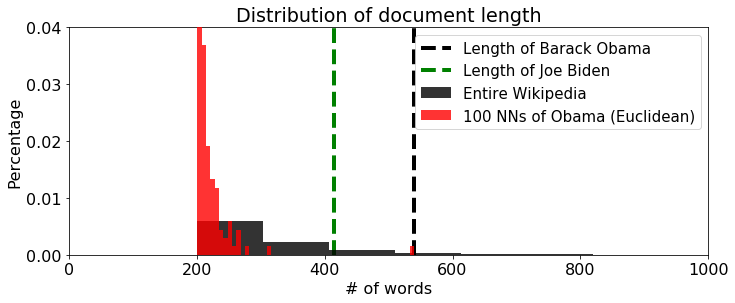

In [370]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values, color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values, color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [371]:
model2_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [376]:
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
nearest_neighbors_names_2 = wiki['name'].iloc[indices[0]]
nearest_neighbors_dist_2 = distances[0]
nearest_neighbors_2 = {'dist': nearest_neighbors_dist_2, 'name': nearest_neighbors_names_2}
nearest_neighbors_2 = pd.DataFrame(nearest_neighbors_2,
                      columns=['dist','name'])
nearest_neighbors_cosine = pd.DataFrame.merge(nearest_neighbors_2, wiki[['name', 'length']], on='name')
#nearest_neighbors_cosine = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
nearest_neighbors_cosine.head(5)

,dist,name,length
0,0.000000,Barack Obama,540
1,0.703139,Joe Biden,414
2,0.742982,Samantha Power,310
3,0.758358,Hillary Rodham Clinton,580
4,0.770561,Eric Stern (politician),255


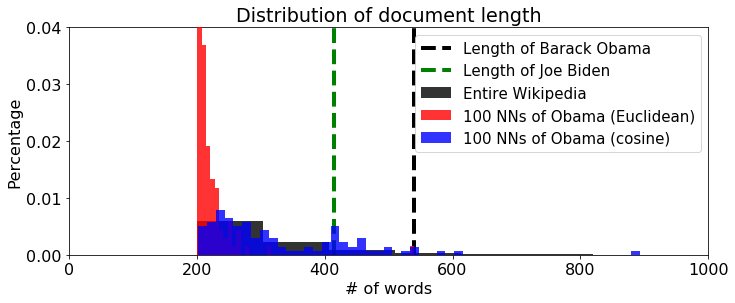

In [377]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values, color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values, color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()